In [144]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

In [145]:
base_path = Path('../experiments')

In [146]:
!ls ../experiments

Untitled.ipynb                         pend_mbrl
bac_pend_multistart_2021-07-20         pend_mbrl_epm
bac_pend_multistart_2021-07-22         pend_mbrl_mse
bac_pend_multistart_3mc_2021-07-20     pend_rmbrl
bac_pend_multistart_3mc_2021-07-23     pendbax_2000nms_mse
batch_multi_pend_2021-07-26            pendbax_500nms
batch_multi_pend_3mc_2021-07-27        pendbax_500nms_mse
default_2021-07-26                     pendbax_gpu
default_2021-07-29                     pendulum_3app
eval_pendulum                          pendulum_new
fast_mean_2021-07-19                   pendulum_new_longer
first_pendulum                         pendulum_subset
fixed_in_tight_bac_2021-07-28          profile
goddard_first_try                      rbax_pend
goddard_mbrl                           rbax_pend2
goddard_new                            rbax_pend3
improved_pendbax                       test
long_cem_pendulum                      test0
mbrl_pend_batch_2021-07-27             test2
mbrl_pend_multistart_202

In [161]:
paths = {# 'Model-Based RL': base_path / 'pend_mbrl_mse', 
         # 'Bayesian Active Control': base_path / 'pendulum_new_longer',
         # 'BAC (3app)': base_path / 'pend_3app', 'BAC (1app)': base_path / 'pend_1app',
         # 'BAC (500nms)': base_path / 'pendbax_500nms',
         # 'BAC (EPM)': base_path / 'pend_epm'
         # 'BAC (improved)': base_path / 'test',
         # 'Multistart batch 1 sample': base_path / 'batch_multi_pend_2021-07-26/17-57-26/',
         # 'Multistart batch 3 sample': base_path / 'batch_multi_pend_3mc_2021-07-27/10-39-16/',
         # 'Tight multistart 1mc BAC': base_path / 'tight-pendulum-bac_2021-07-28/01-10-16',
         # 'Tight multistart 3mc BAC': base_path / 'tight-pendulum-bac-3mc_2021-07-28/01-11-08/',
         # 'Tight multistart MBRL': base_path / 'tight-pendulum-bac-mbrl_2021-07-28/01-13-51',
         # 'Fixed start BAC': base_path / 'fixed_in_tight_bac_2021-07-28/17-17-56',
         #'Multistart MBRL': base_path / 'mbrl_pend_batch_2021-07-27/11-21-53',
         # 'Multistart 1 sample good hps': base_path / 'bac_pend_multistart_2021-07-22/16-00-45',
         # 'Multistart 3 sample good hps': base_path / 'bac_pend_multistart_3mc_2021-07-23/11-12-54',
         'New tight multistart BAC': base_path / 'new-tight-pendulum-bac_2021-07-30/11-25-55',
         # 'Tight multistart MBRL': base_path / 'new-tight-pendulum-bac-mbrl_2021-07-30/11-25-29',
         'Multiple hyper one start BAC': base_path / 'pendbac-multigp_2021-08-02/10-07-03/',
         'multi hyper multistart': base_path / 'pendbac-multigp-multistart_2021-08-02/10-06-17/',
         'multi hyper one start BAC 15 init': base_path / 'pendbac-multigp-15init_2021-08-02/16-22-32/',
         
        }

In [162]:
data = {}
for key, path in paths.items():
    info_path = path / 'info.pkl'
    with info_path.open('rb') as f:
        data[key] = pickle.load(f)

In [163]:
data = {}
for key, path in paths.items():
    info_path = path / 'info.pkl'
    with info_path.open('rb') as f:
        data[key] = pickle.load(f)

dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])


(0.0, 1000.0)

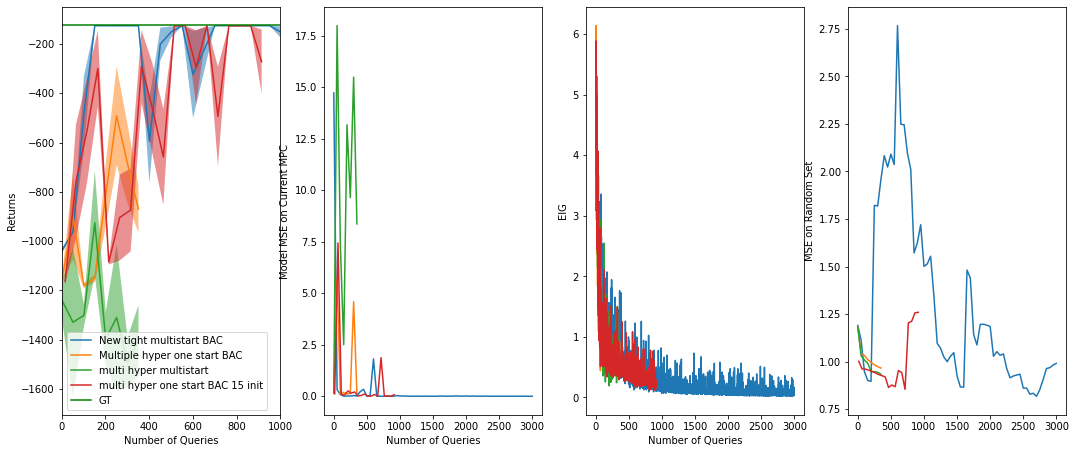

In [164]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for key, vals in data.items():
    print(vals.keys())
    returns = np.array(vals['Eval Returns'])
    rmean = returns.mean(axis=1)
    rstderr = returns.std(axis=1) / np.sqrt(returns.shape[1])
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
    else:
        mses = vals['Model MSE (current MPC)']
    ax2.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax3.plot(acqs, label=key)
    else:
        ax3.plot([], label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax4.plot(ndata, mses, label=key)
        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(-122, color='green', label='GT')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_xlabel('Number of Queries')
ax3.set_ylabel('EIG')
ax4.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax1.set_xlim(0, 1000)